In [2]:
pip install geodatasets


In [22]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import math

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [5]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [6]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [23]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


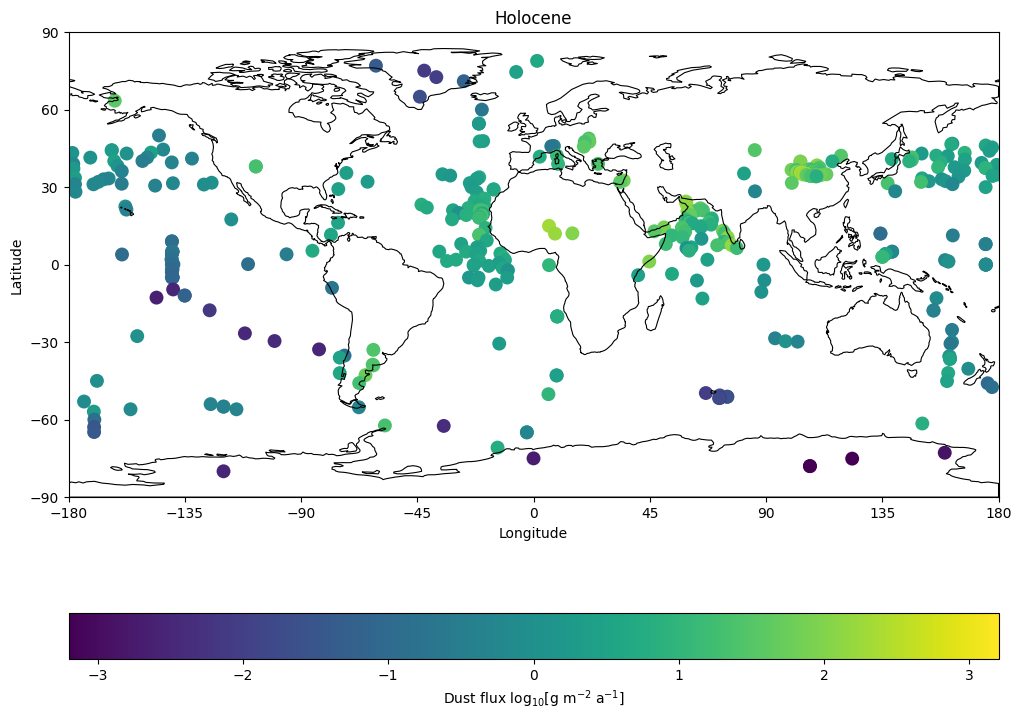

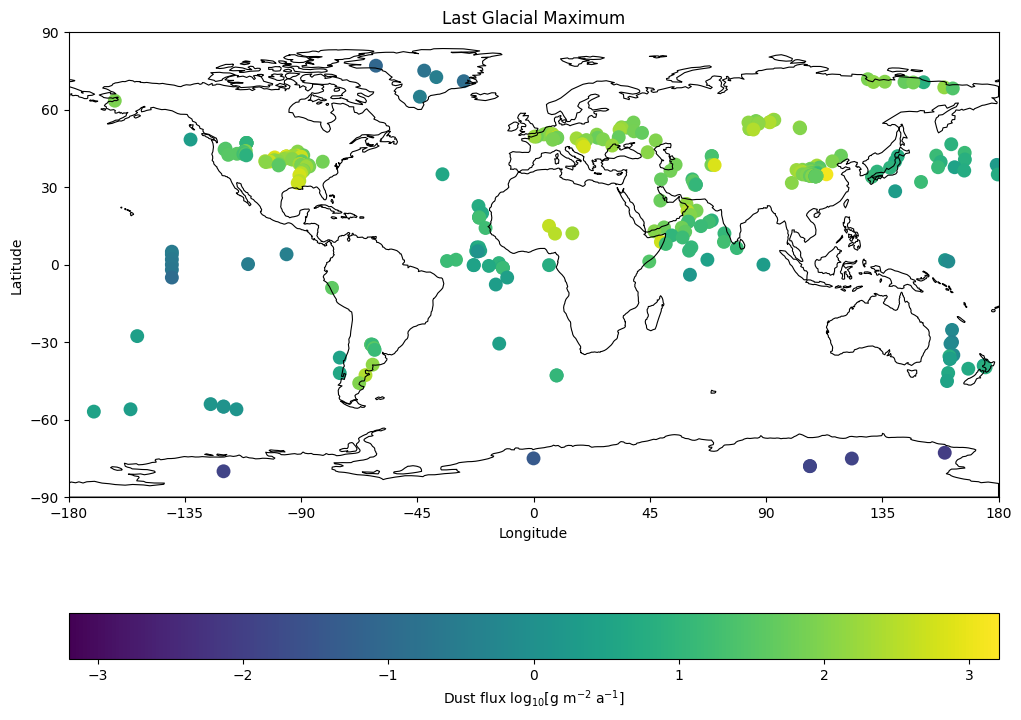

In [8]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [10]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

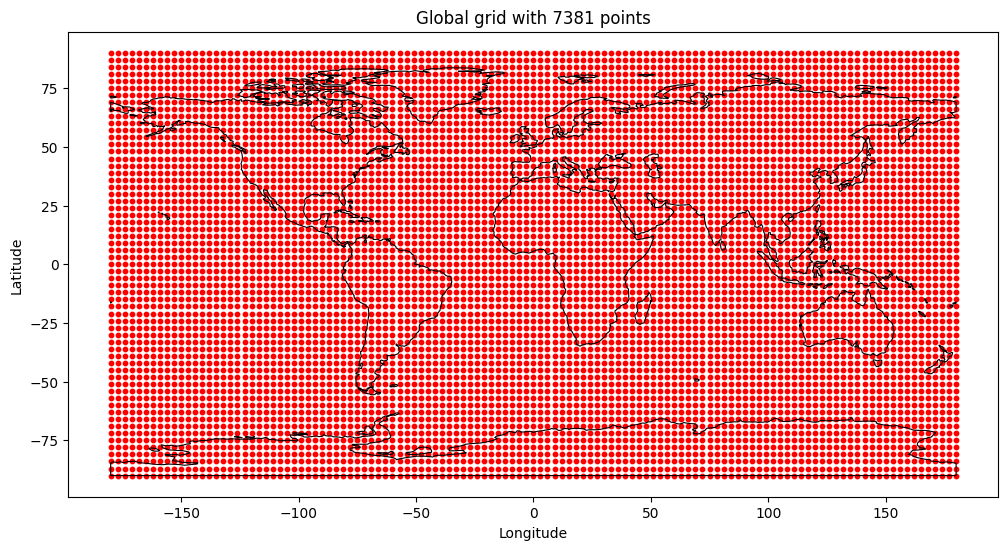

In [11]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [12]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [13]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """

    # Radio tierra en km
    R = 6371.0

    # grados a radianes
    lon1, lat1 = map(math.radians, x)
    lon2, lat2 = map(math.radians, y)

    # fórmula geodésica
    distancia = R * math.acos(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(lon2 - lon1))

    return distancia

In [14]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """

    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean

    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))

    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]

    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)

    return estimation

In [15]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [25]:
estimations_holocene_euclidean = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_euclidean = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_euclidean[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm_euclidean[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol_euclidean"] = estimations_holocene_euclidean
df_global_grid["est_lgm_euclidean"] = estimations_lgm_euclidean

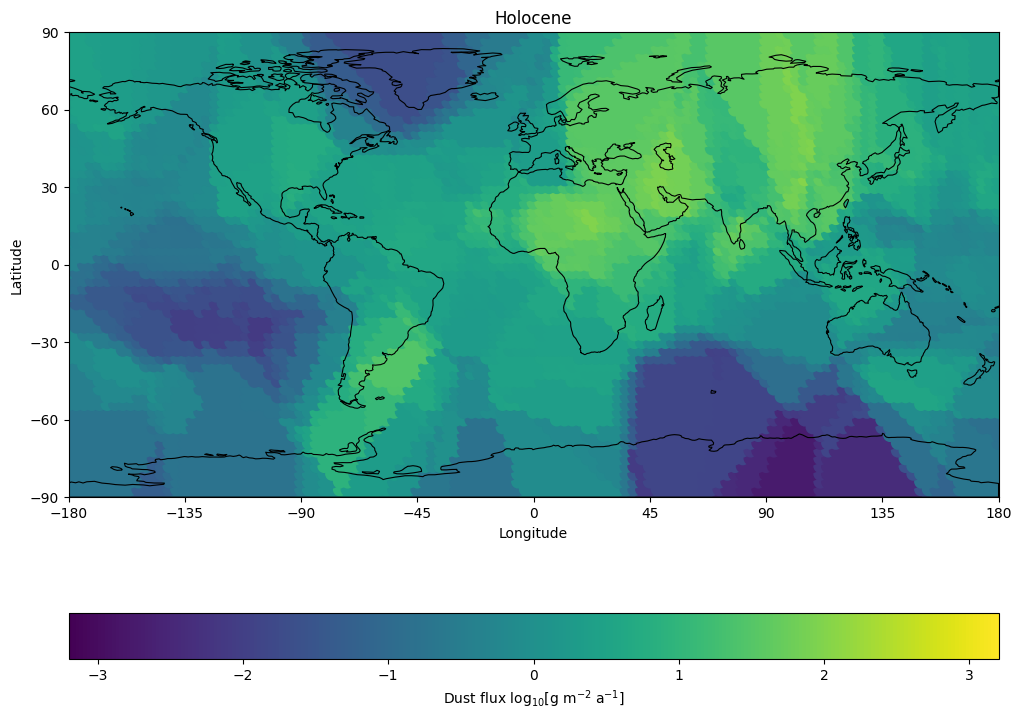

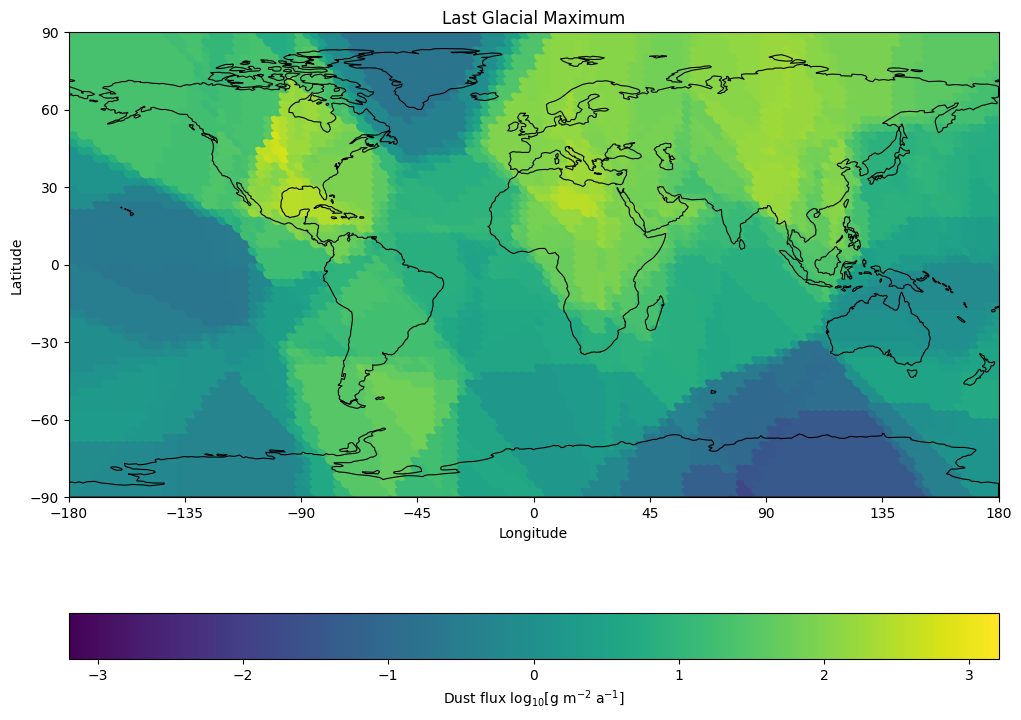

In [27]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_euclidean')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_euclidean')

In [ ]:
n_neighbours = 5

In [28]:
estimations_holocene_geodesic = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geodesic = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geodesic[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geodesic[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geodesic"] = estimations_holocene_geodesic
df_global_grid["est_lgm_geodesic"] = estimations_lgm_geodesic

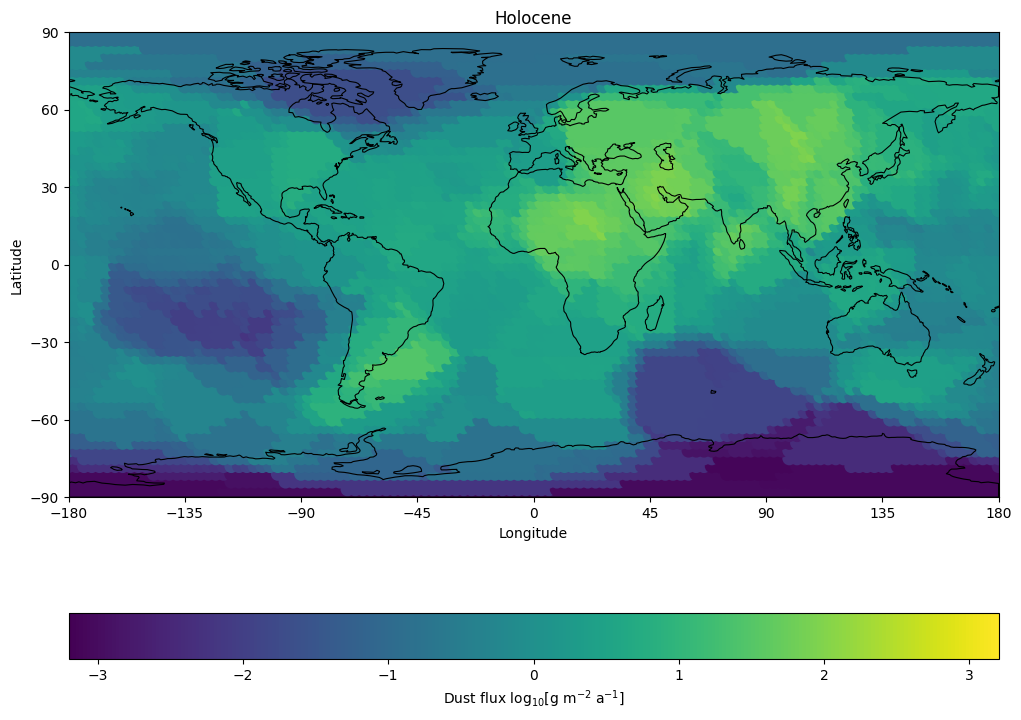

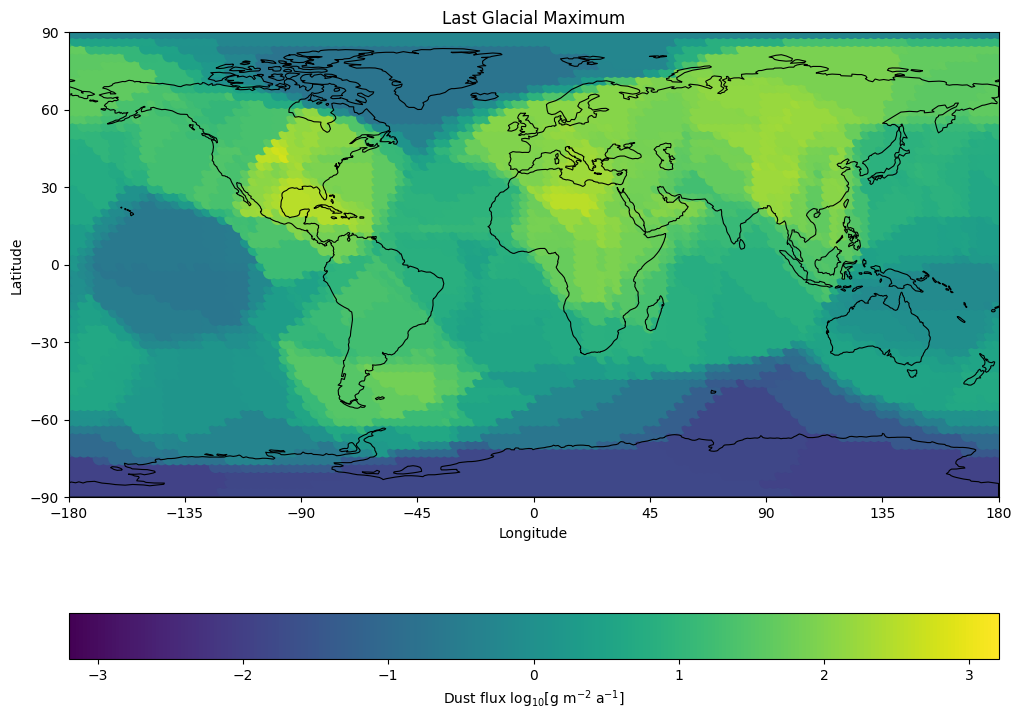

In [38]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_geodesic')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_geodesic')

In [34]:
#diferencias
df_global_grid['diff_hol'] = df_global_grid['est_hol_euclidean'] - df_global_grid['est_hol_geodesic']
df_global_grid['diff_lgm'] = df_global_grid['est_lgm_euclidean'] - df_global_grid['est_lgm_geodesic']


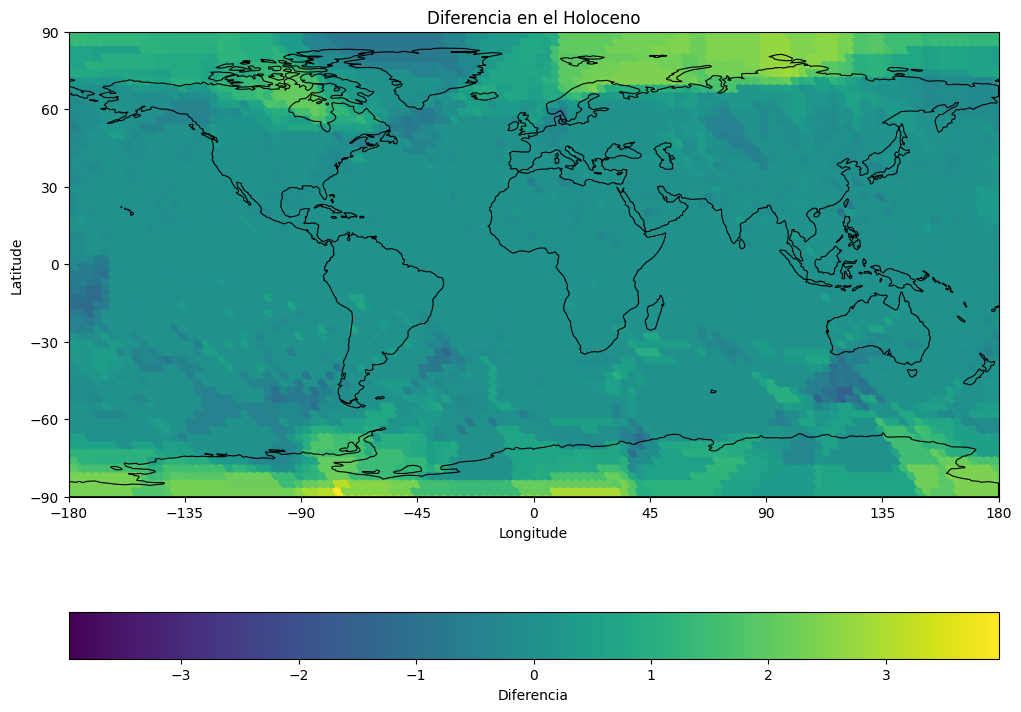

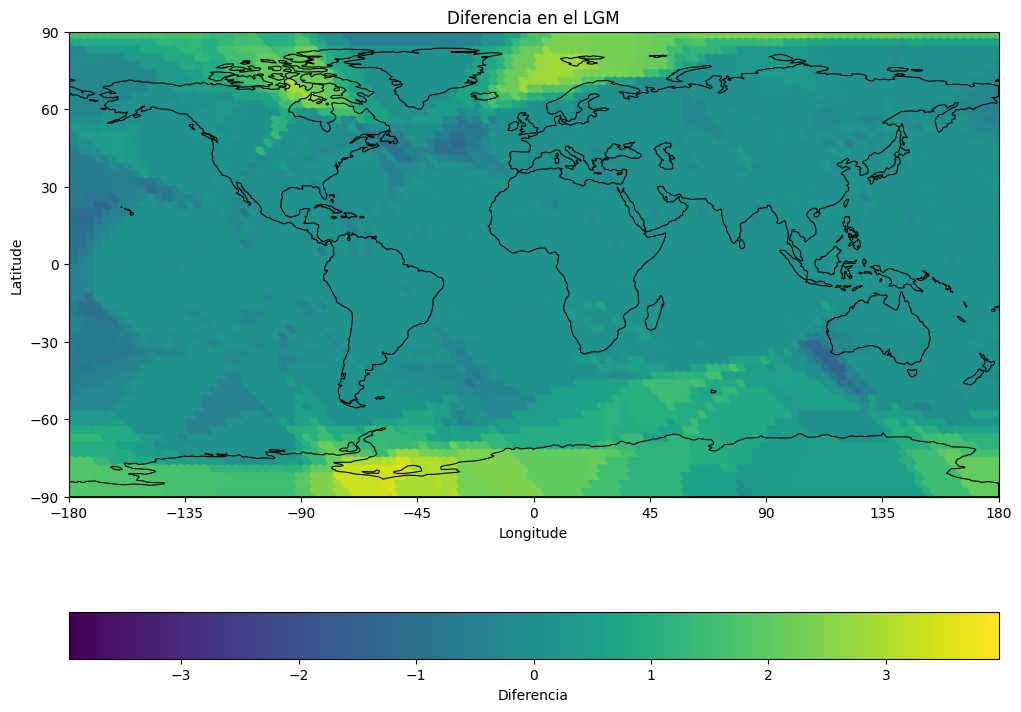

 a) ¿Por que e las diferencias son mas grandes en una parte que otra
 parte del mundo?
lo que ocurre es que la distancia euclidiana considera a dos puntos en un plano por lo que subestima las distancias mientras que la geodesica toma en cuenta la curvatura de la Tierra pero lo calcula como si la Tierra fuera una esfera cuando en realidad la Tierra es mas parecida a un elipsoide, esto hace que los polos al estar achatados la formula geodesica sobreestima las distancias. Segun lo anterior las diferencias en los polos entre la formula euclidiana (que subestima) y la geodesica (sobreestima) van a ser las mas pronunciadas, y eso es lo que se aprecia en la imagen.
b) en los polos la geodesica tendra mejores estimaciones, a pesar de que no sean perfectas, ya que considerar la curvatura lo hace más preciso que la euclidiana.
c) en el caso de las longitudes +-180 ocurre que en un plano, un punto en 180 y otro en -180 estarian extremadamente alejados, de borde a borde, cuando en realidad al tener la Tierra una forma esferica estoy puntos estarian muy cercanos. La distancia euclidiana no esta adaptada para este caso, por lo tanto la geodesica es mas fidedigna.
d)en los resultados del Holoceno y LGM para las distancias euclidianas y geodesicas se diferencian en que las areas de focos de los valores se estiran hacia los polos o visto de otra manera los valores para las distancias geodesicas se achatan hacia el ecuador.
 E)para elegir el numero de vecinos cercanos hay que buscar un balance entre sesgo y varianza para que se visualizen los datos y sus predicciones de la mejor manera . al aumentar los k, los focos de puntos y los dust flux se iran expandiendo y diluyendo en el mapa lo que disminuye la variación y aumenta el sesgo. si se disminuyen los k los focos de los datos seran mas marcados lo que reduce el sesgo y disminuye la varianza. El desafio esta en disminuir el error lo mas poible

In [39]:
n_neighbours = 10

In [40]:
estimations_holocene_geodesic = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geodesic = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geodesic[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geodesic[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geodesic"] = estimations_holocene_geodesic
df_global_grid["est_lgm_geodesic"] = estimations_lgm_geodesic

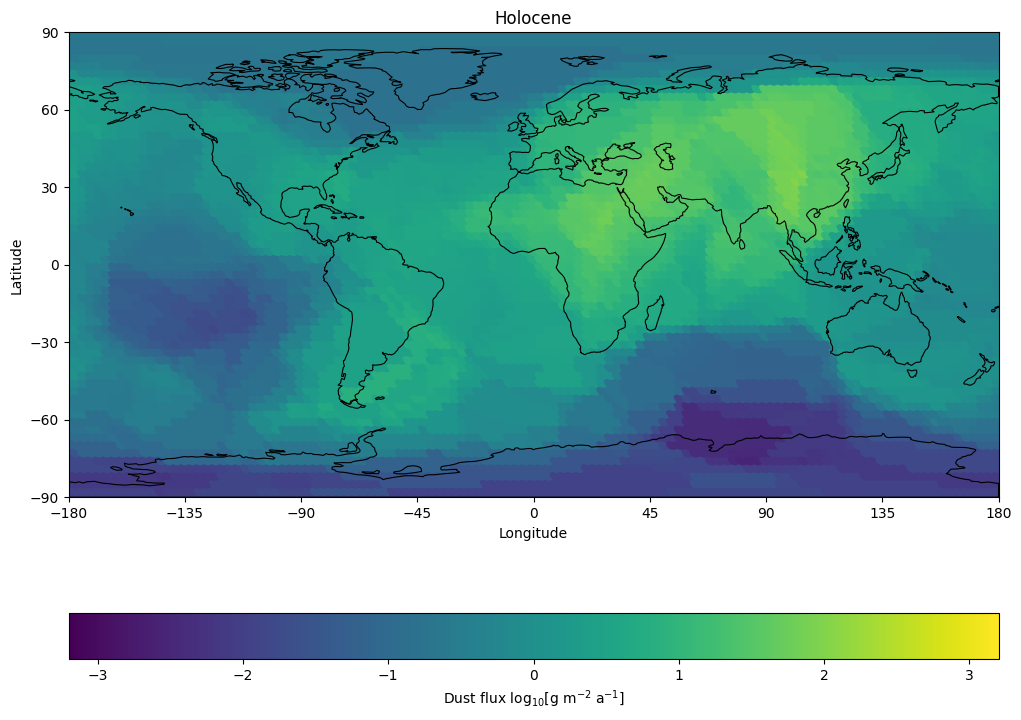

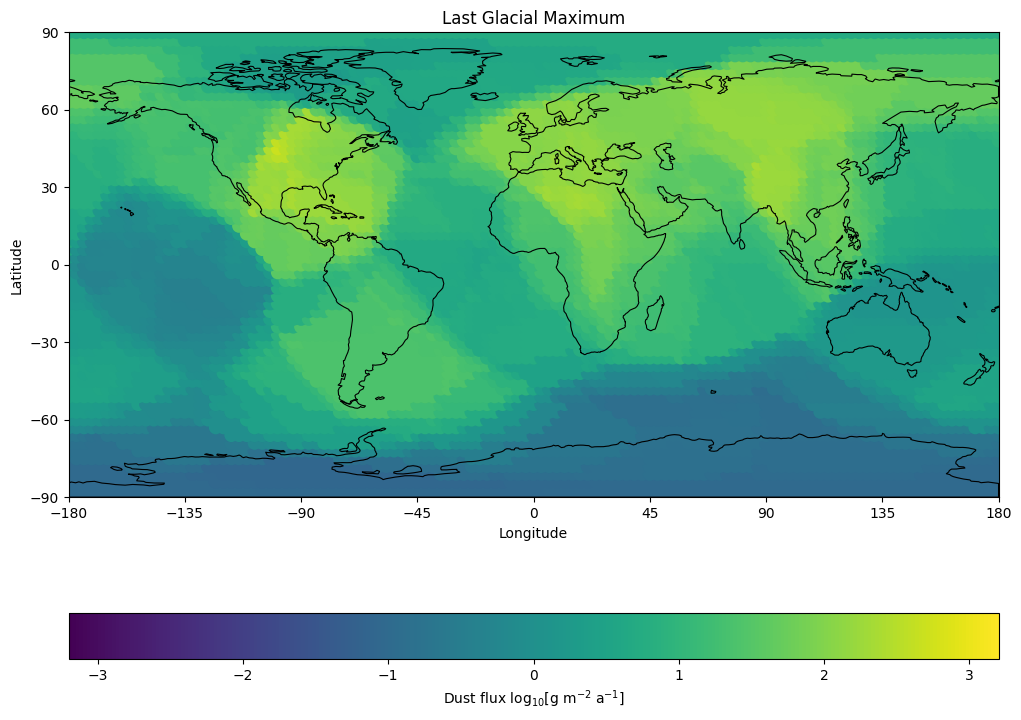

In [41]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_geodesic')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_geodesic')

b)